# Detecting Kermit and Waldorf & Statler based on visual features

This document documents our approach to detect Kermit and Waldorf and Statler based on visual feature engineering.
We employ a support vector machine classifier to predict the characters based on different visual-engineering features used for character detection.

Time Sheet for this Notebook  
**Alina Ehart**

<table>
<thead>
 <tr>
 <th>Date</th>
 <th>Task</th>
 <th>Hours</th>

 </tr>
</thead>
<tbody>
 <tr>
 <td>6.12.2023</td>
 <td>Setup notebook, dependencies, venv, installations, experimenting with video frame extraction - facing a lot of troubles</td>
 <td>6</td>
 </tr>
 <tr>
 <td>7.12.2023</td>
 <td>Implementing video frame extraction further</td>
 <td>1</td>

 </tr>
 <tr>
 <td>8.12.2023</td>
 <td>Implementing video frame extraction furhter, experimenting with visual feature extraction </td>
 <td>2</td>
 </tr>
 <tr>
 <td>9.12.2023</td>
 <td>Improving video frame extraction, visual feature engineering</td>
 <td>4</td>
 </tr>
 <tr>
 <td>10.12.2023</td>
 <td>Visual Feature Engineering (dominant colour & texture), classification (SVM) </td>
 <td>8</td>
 </tr>
<tr>
 <td>04.01.2024</td>
 <td>Adopting to muppetdataset structure & frame extraction </td>
 <td>8</td>
 </tr><tr>
 <td>06.01.2024</td>
 <td>Visual Feature Engineering (dominant colour & texture), preprocessing & annotation </td>
 <td>7</td>
 </tr><tr>
 <td>07.01.2024</td>
 <td>Visual Feature Engineering (dominant colour & hog features), classification (SVM) </td>
 <td>8</td>
 </tr><tr>
 <td>09.01.2024</td>
 <td>Visual Feature Engineering edge features, try to classify with them </td>
 <td>7</td>
 </tr>
<tr>
 <td>11.01.2024</td>
 <td>Model tuning, trying to predict with edge features, result analysis, discussion </td>
 <td>12</td>
 </tr>
<tr>
 <td>12.01.2024</td>
 <td>result analysis, discussion </td>
 <td>4</td>
 </tr>
</tbody>
</table>

**Daniel Blasko:**

<table>
<thead>
  <tr>
    <th>Date</th>
    <th>Task</th>
    <th>Hours</th>
  </tr>
</thead>
<tbody>
    <tr>
        <td>13.01.2024</td>
        <td>Fix dataframe creation, run feature extraction & dataset generation to create the feature CSV.</td>
        <td>4</td>
  </tr>
  <tr>
    <td>15.01.2024</td>
    <td>Add on notebook formatting and structure.</td>
    <td>1</td>
  </tr>
</tbody>
</table>


In [ ]:
#installing requirements
!pip install -r ../requirements.txt


In [2]:
#imports
%load_ext autoreload
%autoreload 2
import os
import json
import matplotlib.pyplot as plt
import librosa.feature as lf
import librosa
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np
from skimage.io import imread
from skimage import feature
from tqdm import tqdm


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    accuracy_score,
)


import sys

sys.path.append("..")
from utils.MuppetDataset import MuppetDataset
from utils.visual_evaluation import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_global_confusion_matrix,
)

Loading the data
Set booleans to extract the audio/frames from the .avi files, if it has not been done previously.


In [4]:
# setting variables for creating muppet dataset
# both set to false as the data is already extracted
extract_audio = False
extract_frames = False

In [12]:
# creating muppetdataset including frames & annotations
video_paths = [
    "../data/Muppets-02-01-01.avi",
    "../data/Muppets-02-04-04.avi",
    "../data/Muppets-03-04-03.avi",
]
annotation_paths = [
    "../data/GroundTruth_Muppets-02-01-01.csv",
    "../data/GroundTruth_Muppets-02-04-04.csv",
    "../data/GroundTruth_Muppets-03-04-03.csv",
]

dataset = MuppetDataset(video_paths, annotation_paths, extract_audio, extract_frames)

example for handling the data for video 0:

dataset.audio_paths[0]
dataset.audios[0]
dataset.annotations.loc[dataset.annotations.Video == 0]


## Feature Extraction


Visual Feature Extraction
The annotations are at the video frame level. Therefore, we need to compute and extract the visual features on frame level as well. We have 25 frames per second.


In [5]:
# Sanity check of frame extraction
for i in range(3):
    number_annotated_frames = (
        dataset.annotations.loc[dataset.annotations["Video"] == i].Frame_number.max()
        + 1
    )
    number_extracted_frames = len(
        [
            item
            for item in os.listdir(f"../data/video/{i}")
            if os.path.isfile(os.path.join(f"../data/video/{i}", item))
        ]
    )
    assert number_annotated_frames == number_extracted_frames

**Visual Feature 1 - Predominant Color**

For simplicity's sake, we begin with extracting the predominant color of each frame and try to predict character presence on its basis.
With the random training / test split and SVM as classifier this turned out to work pretty well. For the ROC-curve of Kermit I forgot to change the title, that's why it says "Pigs".

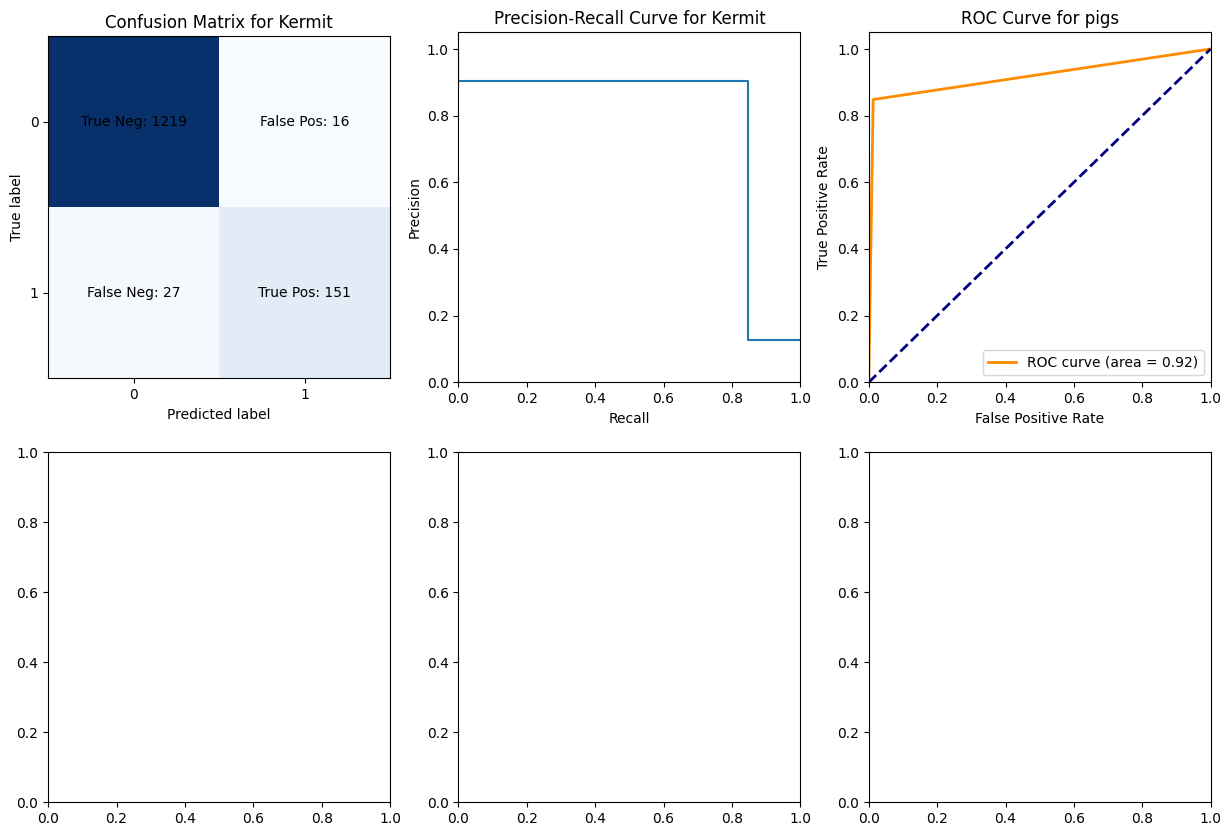
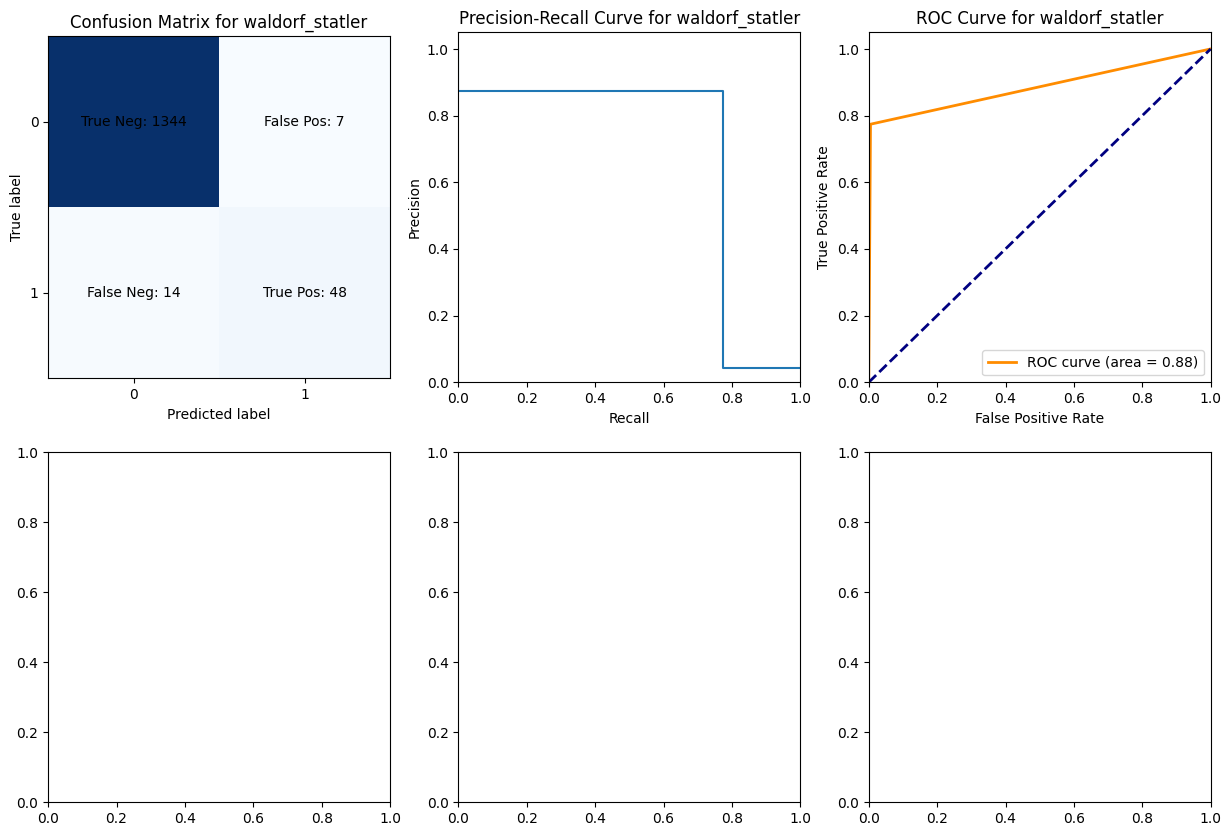


In [6]:
# visual feature extraction
# predominant colour
def get_dominant_color(image):
    pixels = np.float32(image.reshape(-1, 3))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.2)
    _, _, center = cv2.kmeans(pixels, 1, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    dominant_color = center[0].astype(np.uint8)
    return dominant_color

**Visual Feature 2 - HOG Features**

As a second feature we chose HOG (histogram of oriented gradients), which widely is used for object recognition in images on basis of texture features.  
We tried a lot of parameter tweaking and had to go for a trade off between granularity and resource effiency. We ended up with parameters producing results like the following:  
First, we had to reduce the image's resolution to a quater and convert it to grayscale-like. For the pixels per cell 16 x 16 turned out to be a good trade-off. We also tried to go for 32x32 and 64x64 which for sure produced better results, however, the amount of features in the feature vector increased drastically and hence could not be processed by our laptops in a decent amout of time. As to be seen in the following processed images, we anticipate the model to be able to predict character prensence pretty well.  
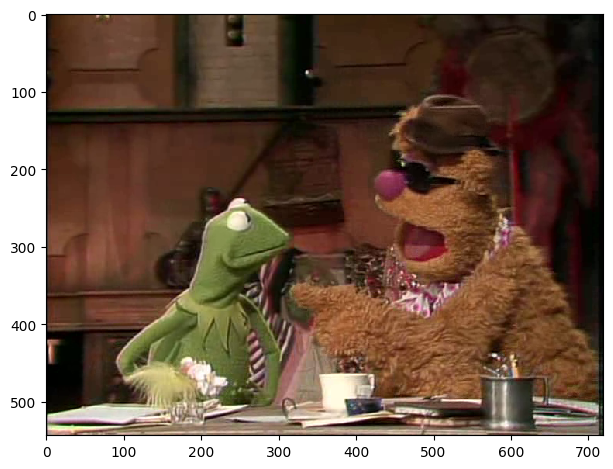
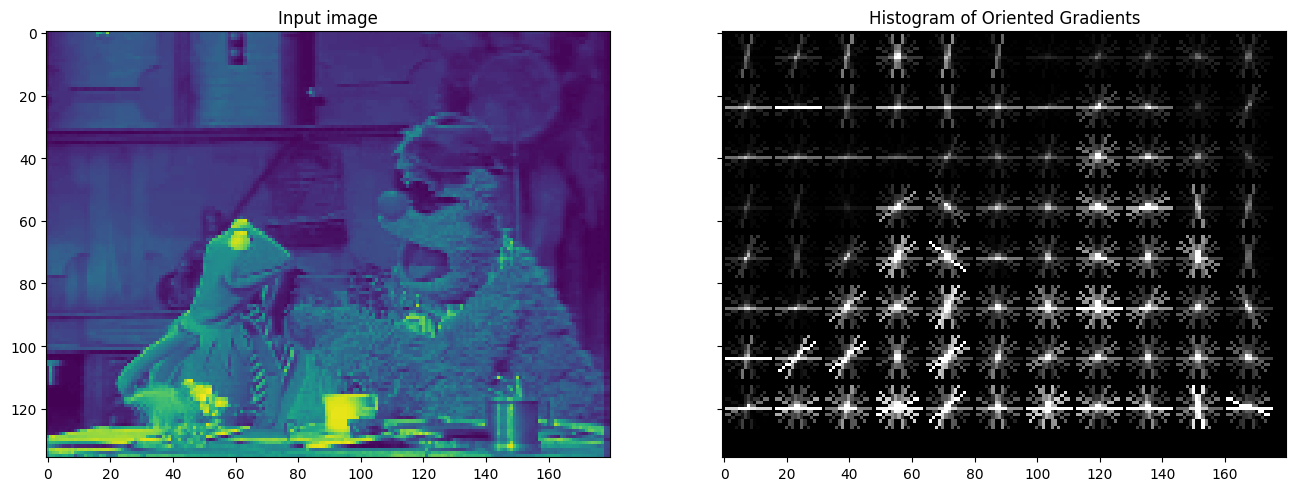


In [6]:
# visual feature extraction
# hog features
from skimage.io import imread, imshow
from skimage.feature import hog
from skimage import exposure
from cv2 import resize


def get_hog_features(image):
    # resizing image to one quater to speed up processing
    image = cv2.resize(image, (image.shape[1] // 4, image.shape[0] // 4))

    # convert image to gray scale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # creating hog features
    fd, hog_image = hog(
        img_gray,
        orientations=9,
        pixels_per_cell=(16, 16),
        cells_per_block=(2, 2),
        visualize=True,
        feature_vector=True,
    )

    # Create a HOG descriptor
    hog_descriptor = cv2.HOGDescriptor()
    # Compute HOG features
    features = hog_descriptor.compute(img_gray)
    # return hog features
    return features

**Visual Feature 3 - Edge Features**

Edge detection aims to identify boundaries within an image, e.g., where significant changes in intesity or color occur. We anticipate to thereby we able to detect characters by their outlines. Again, the image needs to be converted to grayscale and a gaussian blur is applied to reduce noise. The canny edge detector extracted the following edges from a sample frame:  
As one can see, the characters a still clearly recognizable, we hence would anticipate good results for this feature. However, our laptops were not powerful enough to process this kind of feature, after several overnight runs and tries to save into csv file for later usage we unfortunately had to give up on using this feature.  
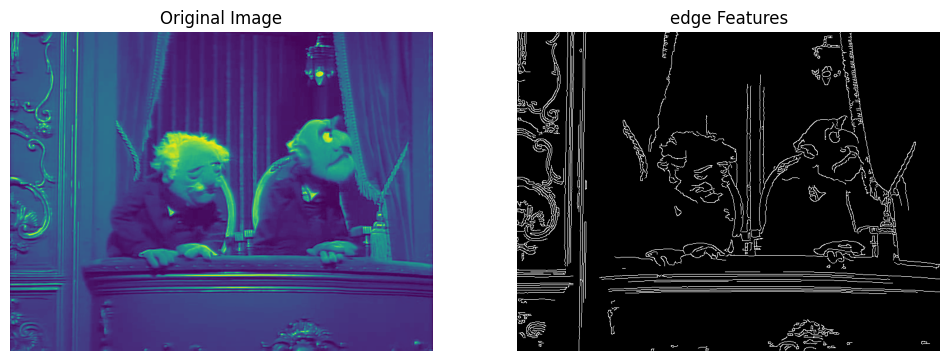


In [4]:
# edge detection
def get_edge_detection(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detector
    edges = cv2.Canny(blurred, 50, 150)
    edge_features = edges.reshape(-1)

    return edge_features

There also has been experimentation on the extraction of color histograms, but as this approach is advised not to be used, we discarded it and did not train the model with them.  
For the following image, the hsv color histogram would look as follows.  
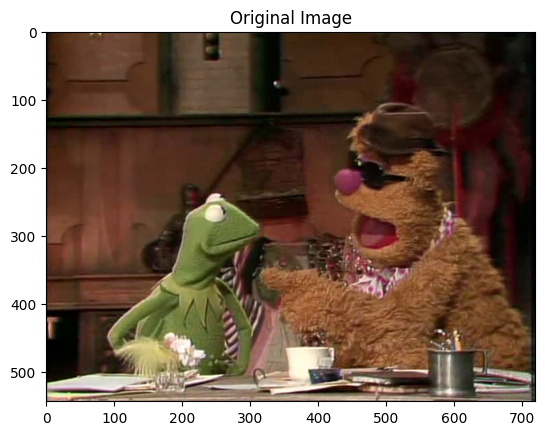
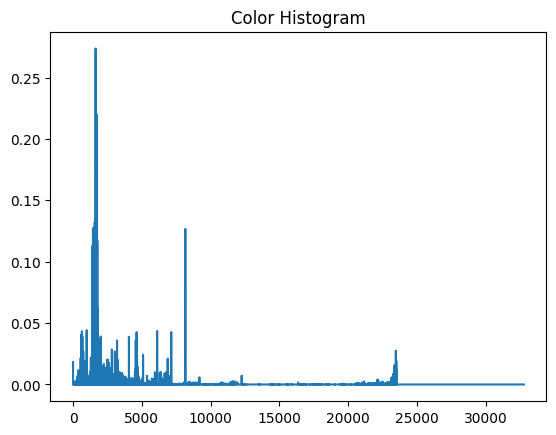


In [ ]:
# unused Visual Feature - color histograms
def extract_color_histogram(image, bins=32, range_val=(0, 256)):
    # Step 2: Read the image

    # Step 3: Convert to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Step 4: Compute color histogram
    hist = cv2.calcHist(
        [hsv_image],
        [0, 1, 2],
        None,
        [bins, bins, bins],
        [
            range_val[0],
            range_val[1],
            range_val[0],
            range_val[1],
            range_val[0],
            range_val[1],
        ],
    )

    # Step 5: Normalize the histogram
    hist = cv2.normalize(hist, hist)

    # Step 6: Flatten and reshape the histogram
    hist = hist.flatten()
    hist = hist.reshape(1, -1)

    return hist

Feature Extraction & Annotation
In the following code block, we extract the visual features from each frame and save them for later usage. We also add the annotions for each frame - regarding which characters are present within each frame.


In [9]:
# feature extractiong & saving to csv file for later usage
import csv

csv_file = "VisualData.csv"
write_header = not os.path.exists(csv_file)
np.set_printoptions(threshold=np.inf)  # Set the threshold to infinity
# setting up columns for csv file
columns = [
    "video_id",
    "frame_id",
    "kermit_present",
    "waldorf_statler_present",
    "predominant_color",
    "hog_features",
]

dataset.video_features = {}
for video_idx in dataset.frames.keys():
    for frame_idx, frame_path in tqdm(
        dataset.frames[video_idx],
        desc="Extracting visual features for video {}".format(video_idx),
        leave=False,
    ):
        frame_path = (
            "../data/video/" + str(video_idx) + "/frame_" + str(frame_idx) + ".png"
        )
        frame = cv2.imread(frame_path)
        predominant_color = get_dominant_color(frame)
        hog_features = get_hog_features(frame)
        edge_featues = get_edge_detection(frame)

        # add features to dataframe
        if video_idx not in dataset.video_features:
            dataset.video_features[video_idx] = {}
            dataset.video_features[video_idx]["frames"] = {}
        dataset.video_features[video_idx]["frames"][frame_idx] = {
            "predominant_color": predominant_color,
            "hog_features": hog_features,
            "edge_features": edge_featues,
        }

Extracting visual features for video 1:  22%|██▏       | 8500/38706 [45:41<3:53:29,  2.16it/s] 

In [22]:
# pickeling data for later usage to have it on disk
import pickle

with open("../results/sim1_visual/features.pkl", "wb") as f:
    pickle.dump(dataset.video_features, f)

        Video  Frame_number  Kermit  Pigs  Audio_Pigs  Cook  Audio_Cook  \
0           0             0       0     0           0     0           0   
1           0             1       0     0           0     0           0   
2           0             2       0     0           0     0           0   
3           0             3       0     0           0     0           0   
4           0             4       0     0           0     0           0   
...       ...           ...     ...   ...         ...   ...         ...   
115880      2         38493       0     0           0     0           0   
115881      2         38494       0     0           0     0           0   
115882      2         38495       0     0           0     0           0   
115883      2         38496       0     0           0     0           0   
115884      2         38497       0     0           0     0           0   

        StatlerWaldorf  Audio_StatlerWaldorf  Audio_MissPiggy  
0                    0             

In [ ]:
# add annotations
video_features = video_features.merge(
    dataset.annotations[["Video", "Frame_number", "Kermit", "Statler_Waldorf"]],
    how="left",
    left_on=["video_idx", "frame_idx"],
    right_on=["Video", "Frame_number"],
)
video_features = video_features.drop(columns=["Frame_number", "Video"])

In [ ]:
# merging features from csv
video_features1 = pd.read_csv("")
video_features2 = pd.read_csv("")

video_features = pd.merge(
    video_features1,
    video_features2,
    on=["video_idx", "frame_idx", "Kermit", "Statler_Waldorf"],
    how="inner",
).drop(columns=["Unnamed: 0x", "Unnamed: 0y"], axis=1)

As the amounts of feature data are very large, we processed them seperately and saved them into a csv file for later usage. During feature extraction processing times even exceeded 24h several times, but all data again got lost due to oom or laptop crashes. So we executed feature extraction on more powerful hardware and saved it to csv to use it here.


In [6]:
# get data from csv and sava as df
dataframe = pd.read_csv("all_no_edge_features.csv")
dataframe.sample(10)

,Unnamed: 0,video_idx,frame_idx,hog_0,hog_1,hog_2,hog_3,hog_4,hog_5,hog_6,...,hog_2515,hog_2516,hog_2517,hog_2518,hog_2519,predom_color_0,predom_color_1,predom_color_2,Kermit,StatlerWaldorf
98498,98498,2,21111,0.278138,0.044461,0.008919,0.054559,0.278138,0.026277,0.042950,...,0.163041,0.104058,0.157203,0.157630,0.171570,52,62,71,0,0
48387,48387,1,9706,0.297252,0.018521,0.045946,0.031864,0.297252,0.080668,0.050349,...,0.129061,0.142817,0.073805,0.080025,0.062089,46,72,96,0,0
57110,57110,1,18429,0.221707,0.109629,0.129617,0.154907,0.221707,0.177608,0.221707,...,0.085560,0.158884,0.235183,0.087232,0.084165,129,114,145,1,0
26198,26198,0,26198,0.468962,0.165576,0.069303,0.016568,0.032583,0.000000,0.001245,...,0.033153,0.004196,0.026539,0.012589,0.001978,87,100,137,0,0
33235,33235,0,33235,0.029239,0.000000,0.007753,0.000000,0.030458,0.002724,0.005169,...,0.012493,0.005089,0.031889,0.033911,0.117517,40,41,58,0,0
63543,63543,1,24862,0.493130,0.032221,0.019039,0.013379,0.068808,0.010034,0.014808,...,0.181091,0.047242,0.124205,0.127130,0.046877,87,91,103,0,0
106536,106536,2,29149,0.250881,0.198881,0.203195,0.058227,0.093760,0.076691,0.046033,...,0.124397,0.097238,0.240158,0.277746,0.277746,65,86,97,0,0
38054,38054,0,38054,0.264555,0.240299,0.264555,0.086038,0.199822,0.100677,0.141620,...,0.113363,0.014757,0.034816,0.026053,0.010760,54,59,80,0,0
73779,73779,1,35098,0.366724,0.121132,0.094648,0.052602,0.140952,0.018312,0.013378,...,0.254963,0.254963,0.254963,0.200260,0.238591,74,103,129,1,0
15577,15577,0,15577,0.122528,0.004827,0.011295,0.007769,0.070522,0.006827,0.026001,...,0.275573,0.053983,0.030223,0.023391,0.007580,137,152,170,0,0


extracting X and y matrices for the ML model


In [7]:
# x, y split
# dataframe.drop("Unnamed: 0",axis=1)
X = dataframe.drop(
    columns=["Kermit", "StatlerWaldorf", "video_idx", "frame_idx", "Unnamed: 0"]
)
y = dataframe[["Kermit", "StatlerWaldorf"]]

And then split into train and test sets by 80/20 ratio. However, we do not use a shuffled random split like one would often use in tabular-data machine learning: this would lead to test-set contamination, as neighboring frames are highly correlated, and we would have such neighboring frames in both the train and test sets.
However, to observe the difference in results, we implemented both the random and non-random approaches and tried out both in the audio notebook.

Due to this reasoning, we decide to use the first 80% of the ordered frames as training data and the last 20% as testing data.


In [8]:
RANDOM_SPLIT = True

In [9]:
if RANDOM_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
else:
    X_train = X.head(int(X.shape[0] * 0.8))
    X_test = X.tail(int(X.shape[0] * 0.2))
    y_train = y.head(int(y.shape[0] * 0.8))
    y_test = y.tail(int(y.shape[0] * 0.2))

assert X.shape[0] == X_train.shape[0] + X_test.shape[0]
assert y.shape[0] == y_train.shape[0] + y_test.shape[0]

## Model training and evaluation


Scaling the data with a standardScaler to Z-score normalization, ensuring zero mean and unit variance to better fit the SVM classifier.


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Training the video-based model
For this task, we decided to use a SVM classifier. For simplicity's sake, we trained two seperated models: one for detecting Kermit and one for detecting Waldorf & Statler to avoid multiclass classification.

Important remark: we notice that Kermit is the only character where, in the ground truth, the presence is annotated through a single column that does not distinguish between audio and vision. Therefore, we expected the performance of this audio-based model to be worse for Kermit based on evaluation metrics.


In [11]:
# training model for Kermit
from sklearn.svm import SVC

svm_classifier_kermit = SVC()

svm_classifier_kermit.fit(X_train_scaled, y_train["Kermit"])

y_pred_kermit = svm_classifier_kermit.predict(X_test_scaled)

As we can see in the metrics and visuals, this approach works very well. So, it is a little less sad that we could not process the edge features for classificatin on our hardware.


Accuracy: 0.9955559390775338
Precision: 0.9921104536489151
Recall: 0.9922610015174507
F1 Score: 0.9921857218723921
Confusion Matrix:
[[16535    52]
 [   51  6539]]


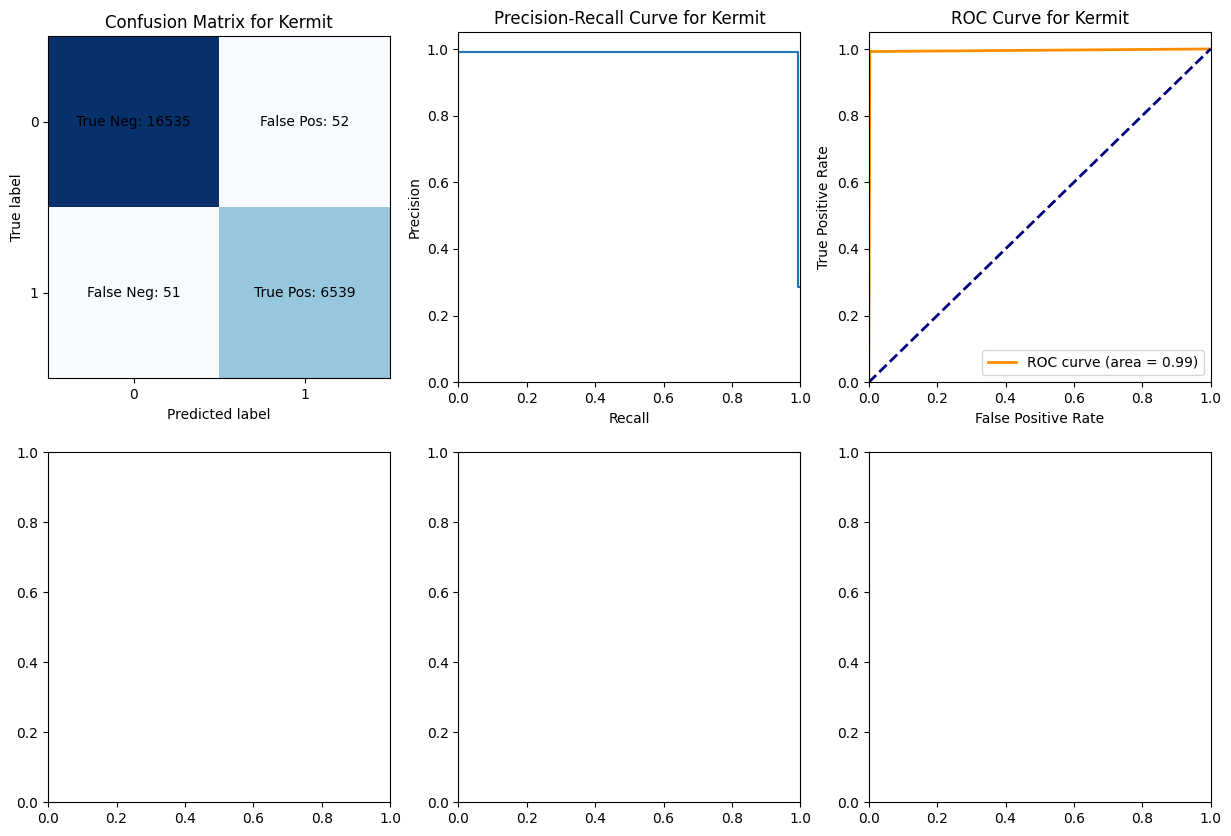

In [13]:
# Evaluation metrics for Kermit
# Kermit
accuracy = accuracy_score(y_test["Kermit"], y_pred_kermit)
precision = precision_score(y_test["Kermit"], y_pred_kermit)
recall = recall_score(y_test["Kermit"], y_pred_kermit)
f1 = f1_score(y_test["Kermit"], y_pred_kermit)
conf_matrix = confusion_matrix(y_test["Kermit"], y_pred_kermit)

# Print the metrics
print("Metrics for Kermit: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Kermit"], y_pred_kermit, "Confusion Matrix for Kermit", ax=axs[0, 0]
)
plot_precision_recall_curve(
    y_test["Kermit"], y_pred_kermit, "Precision-Recall Curve for Kermit", ax=axs[0, 1]
)
plot_roc_curve(y_test["Kermit"], y_pred_kermit, "ROC Curve for Kermit", ax=axs[0, 2])

In [14]:
# train model for waldorfstatler
from sklearn.svm import SVC

svm_classifier_ws = SVC()

svm_classifier_ws.fit(X_train_scaled, y_train["StatlerWaldorf"])

y_pred_ws = svm_classifier_ws.predict(X_test_scaled)

Also for waldorf & statler this approach worked quite well.


Accuracy: 0.999007636881391
Precision: 0.9830747531734838
Recall: 0.9844632768361582
F1 Score: 0.9837685250529287
Confusion Matrix:
[[22457    12]
 [   11   697]]


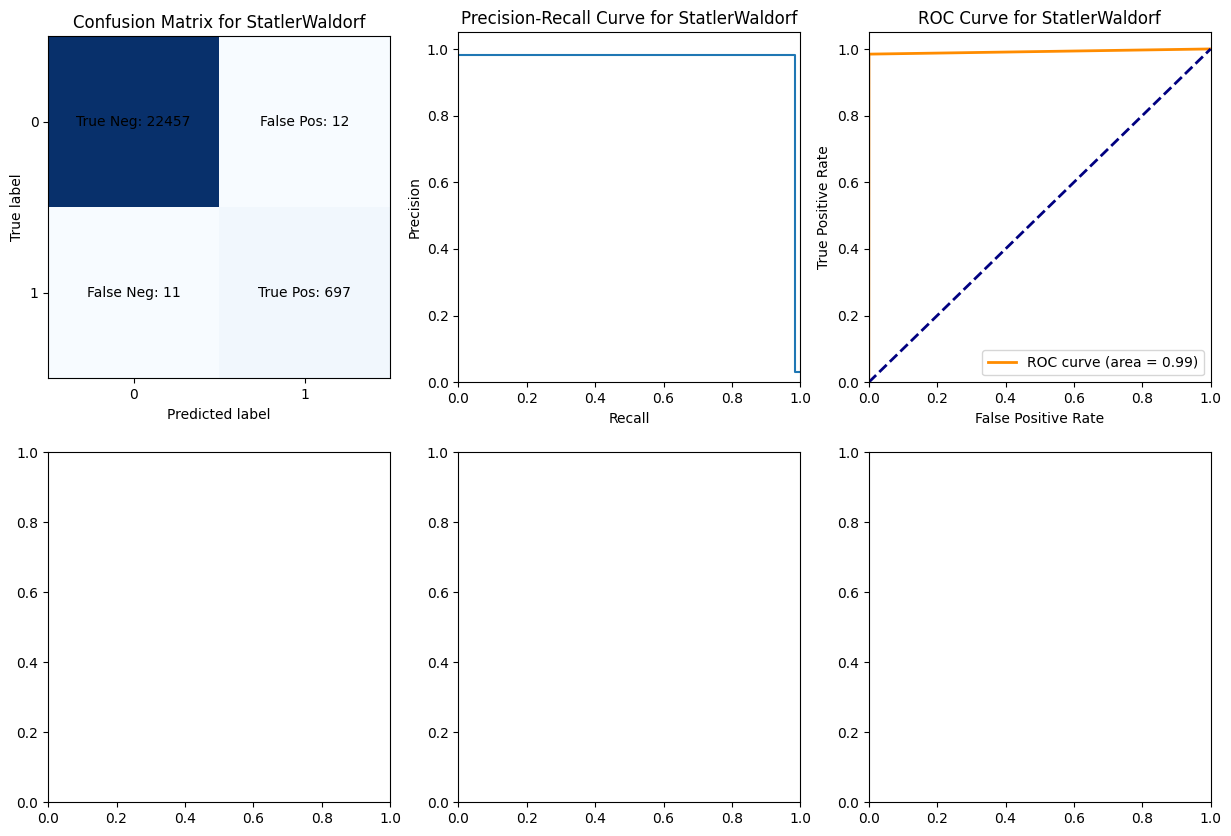

In [15]:
# Evaluate metrics for WaldorfStatler

accuracy = accuracy_score(y_test["StatlerWaldorf"], y_pred_ws)
precision = precision_score(y_test["StatlerWaldorf"], y_pred_ws)
recall = recall_score(y_test["StatlerWaldorf"], y_pred_ws)
f1 = f1_score(y_test["StatlerWaldorf"], y_pred_ws)
conf_matrix = confusion_matrix(y_test["StatlerWaldorf"], y_pred_ws)

# Print the metrics
print("Metrics for Waldorf & Statler")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["StatlerWaldorf"],
    y_pred_ws,
    "Confusion Matrix for StatlerWaldorf",
    ax=axs[0, 0],
)
plot_precision_recall_curve(
    y_test["StatlerWaldorf"],
    y_pred_ws,
    "Precision-Recall Curve for StatlerWaldorf",
    ax=axs[0, 1],
)
plot_roc_curve(
    y_test["StatlerWaldorf"], y_pred_ws, "ROC Curve for StatlerWaldorf", ax=axs[0, 2]
)

Besides the seperated metrics for the two sepeated models, we also calculated metrics for both of the models combined. Therefore, we had to add a new column for combined occurrences of Kermit and Waldorf & Statler. The new column in the y_test dataframe is called "combined". Its values are computed as follows: 2\*["StatlerWaldorf"]+["Kermit"].
As a result we have the following values indicating presences:
0: no character present
1: Kermit present
2: Waldorf&Statler present
3: Kermit and Waldorf&Statler present

In a similar way, we also had to combine the models' predictions. Therefore, we combined the array elements in the same manner:
combined_pred = y_pred_ws \* 2 + y_pred
Resulting in the same character presence indication values


In [ ]:
# combined evaluation
y_test.sample()
y_pred_kermit.sample()
y_pred_ws.sample()
# y_test["combined"] = y_test['StatlerWaldorf']*2 + y_test["Kermit"]

In [28]:
# combining predictions
print(y_pred)
print(y_pred_ws)
combined_pred = y_pred_ws * 2 + y_pred_kermit
print(combined_pred)

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


As we can see from the metrics, the model overall performs good as well.


Accuracy: 0.9946930146265694
Precision: 0.9946937646226277
Recall: 0.9946930146265694
F1 Score: 0.9946933703267501
Confusion Matrix:
[[15818    52     9]
 [   48  6539     3]
 [   11     0   697]]


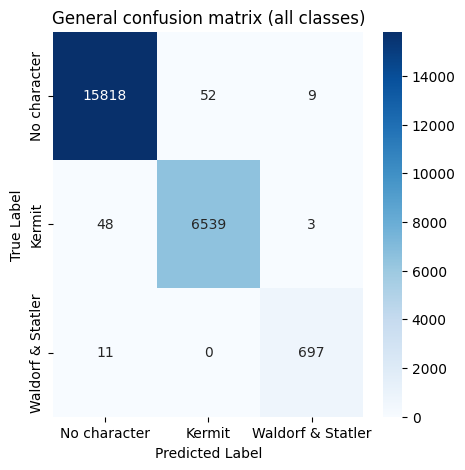

In [33]:
# combined evaluation metrics
# Compute metrics for the general classifier as a whole
accuracy_general = accuracy_score(y_test["combined"], combined_pred)
precision_general = precision_score(
    y_test["combined"], combined_pred, average="weighted"
)
recall_general = recall_score(y_test["combined"], combined_pred, average="weighted")
f1_general = f1_score(y_test["combined"], combined_pred, average="weighted")
conf_matrix_general = confusion_matrix(y_test["combined"], combined_pred)

print(f"Accuracy: {accuracy_general}")
print(f"Precision: {precision_general}")
print(f"Recall: {recall_general}")
print(f"F1 Score: {f1_general}")
print(f"Confusion Matrix:\n{conf_matrix_general}")

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

plot_global_confusion_matrix(
    y_test["combined"],
    combined_pred,
    "Kermit",
    "Waldorf & Statler",
)

Training Model and predict on basis of predominant color only
In the following cells, we train the svm models for kermit and StatlerWaldorf solely on the predominant color features and evaluate how well that works.


In [40]:
# training model with predominant color only
print(X_train)
X_train_pdc = X_train.drop(X_train.filter(like="hog_").columns, axis=1)
X_train_pdc.sample()

           hog_0     hog_1     hog_2     hog_3     hog_4     hog_5     hog_6  \
72293   0.454830  0.338786  0.239704  0.110791  0.180218  0.020844  0.017577   
51495   0.226360  0.285382  0.285382  0.285382  0.285382  0.106999  0.043093   
21904   0.122005  0.052061  0.024182  0.214173  0.393201  0.069221  0.021361   
56288   0.362570  0.139728  0.096494  0.008771  0.050677  0.010116  0.025095   
6134    0.345429  0.218942  0.154820  0.089535  0.180133  0.080144  0.052346   
...          ...       ...       ...       ...       ...       ...       ...   
76820   0.182208  0.000000  0.026429  0.010447  0.154176  0.010447  0.019822   
110268  0.212922  0.063925  0.063056  0.100386  0.121806  0.097164  0.048851   
103694  0.243267  0.113518  0.081543  0.111665  0.160399  0.043057  0.082321   
860     0.169813  0.027547  0.008587  0.054931  0.150553  0.115173  0.065815   
15795   0.051872  0.008245  0.151128  0.095822  0.201984  0.034101  0.042866   

           hog_7     hog_8     hog_9  .

,predom_color_0,predom_color_1,predom_color_2
15933,135,144,160


In [44]:
# scale it
# X_train_pdc_scaled = scaler.fit_transform(X_train_pdc)

# same for X-test
X_test_pdc = X_test.drop(X_test.filter(like="hog_").columns, axis=1)
X_test_pdc_scaled = scaler.fit_transform(X_test_pdc)

In [45]:
# training model for pdc only - Kermit
svm_pdc_kermit = SVC()

svm_pdc_kermit.fit(X_train_pdc_scaled, y_train["Kermit"])
y_pred_kermit_pdc = svm_pdc_kermit.predict(X_test_pdc_scaled)

In [48]:
# training model for pdc only - StatlerWaldorf
svm_pdc_ws = SVC()

svm_pdc_ws.fit(X_train_pdc_scaled, y_train["StatlerWaldorf"])
y_pred_ws_pdc = svm_pdc_ws.predict(X_test_pdc_scaled)

Metrics for Kermit Predominant Color only: 
Accuracy: 0.828752642706131
Precision: 0.800918484500574
Recall: 0.5292867981790592
F1 Score: 0.6373686614892644
Confusion Matrix:
[[15720   867]
 [ 3102  3488]]


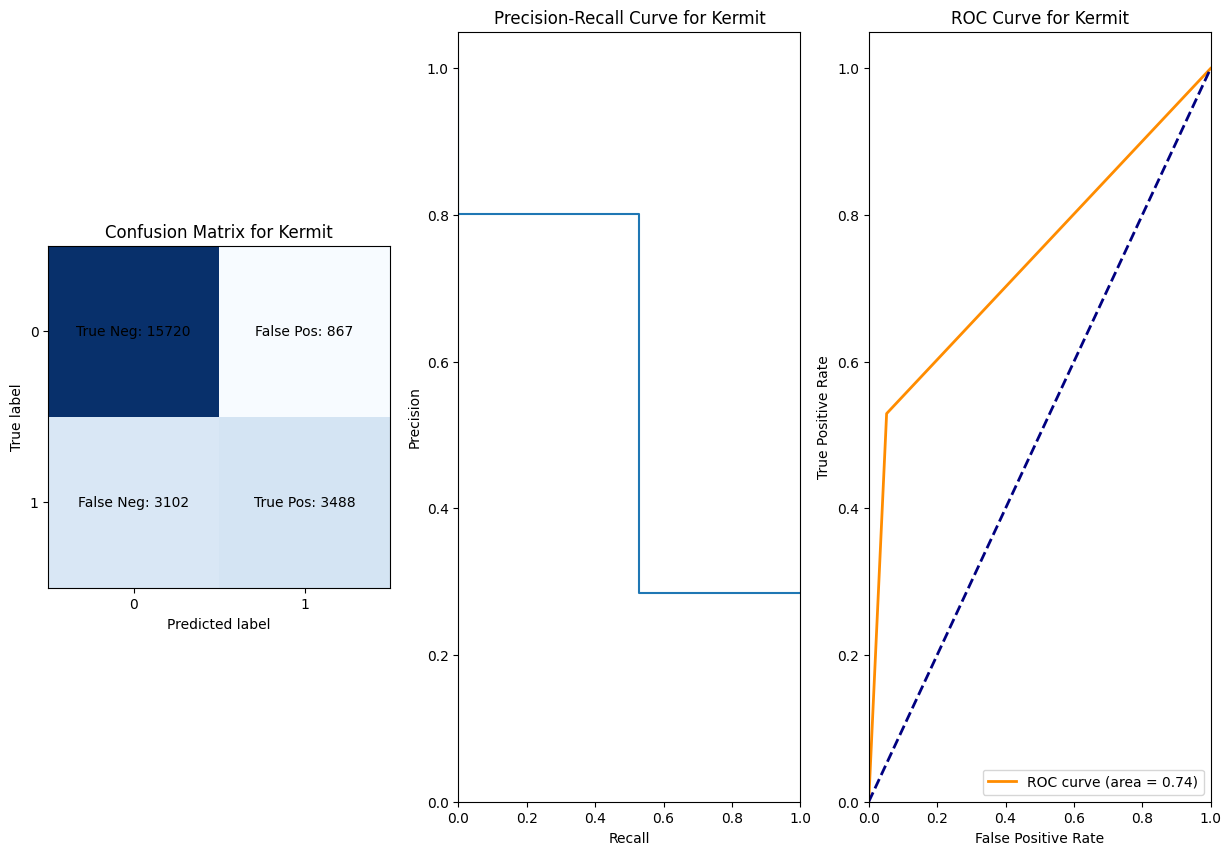

In [47]:
# Evaluation metrics for Kermit
# Kermit
accuracy = accuracy_score(y_test["Kermit"], y_pred_kermit_pdc)
precision = precision_score(y_test["Kermit"], y_pred_kermit_pdc)
recall = recall_score(y_test["Kermit"], y_pred_kermit_pdc)
f1 = f1_score(y_test["Kermit"], y_pred_kermit_pdc)
conf_matrix = confusion_matrix(y_test["Kermit"], y_pred_kermit_pdc)

# Print the metrics
print("Metrics for Kermit Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Kermit"], y_pred_kermit_pdc, "Confusion Matrix for Kermit", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Kermit"], y_pred_kermit_pdc, "Precision-Recall Curve for Kermit", ax=axs[1]
)
plot_roc_curve(y_test["Kermit"], y_pred_kermit_pdc, "ROC Curve for Kermit", ax=axs[2])

Metrics for StatlerWaldorf Predominant Color only: 
Accuracy: 0.9861069163394744
Precision: 0.7365196078431373
Recall: 0.8488700564971752
F1 Score: 0.7887139107611548
Confusion Matrix:
[[22254   215]
 [  107   601]]


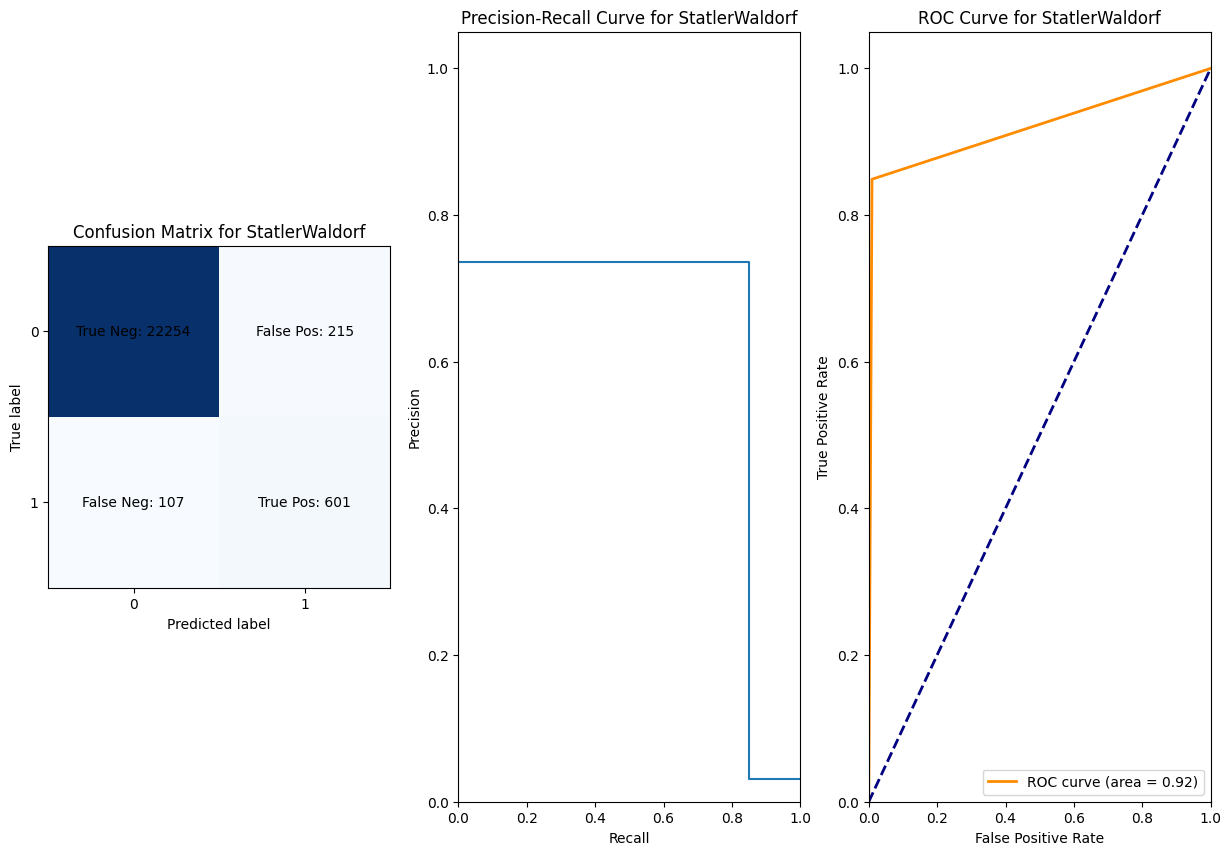

In [51]:
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["StatlerWaldorf"], y_pred_ws_pdc)
precision = precision_score(y_test["StatlerWaldorf"], y_pred_ws_pdc)
recall = recall_score(y_test["StatlerWaldorf"], y_pred_ws_pdc)
f1 = f1_score(y_test["StatlerWaldorf"], y_pred_ws_pdc)
conf_matrix = confusion_matrix(y_test["StatlerWaldorf"], y_pred_ws_pdc)

# Print the metrics
print("Metrics for StatlerWaldorf Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["StatlerWaldorf"],
    y_pred_ws_pdc,
    "Confusion Matrix for StatlerWaldorf",
    ax=axs[0],
)
plot_precision_recall_curve(
    y_test["StatlerWaldorf"],
    y_pred_ws_pdc,
    "Precision-Recall Curve for StatlerWaldorf",
    ax=axs[1],
)
plot_roc_curve(
    y_test["StatlerWaldorf"], y_pred_ws_pdc, "ROC Curve for StatlerWaldorf", ax=axs[2]
)

**HOG_features only**  
Training Model and predict on basis of hog features only  
In the following cells, we train the svm models for kermit and StatlerWaldorf solely on the hog features and evaluate how well that works.


In [53]:
X_train_hog = X_train.drop(X_train.filter(like="predominant_color_").columns, axis=1)


# same for X-test
X_test_hog = X_test.drop(X_test.filter(like="predominant_color_").columns, axis=1)
# scale it
X_train_hog_scaled = scaler.fit_transform(X_train_hog)
X_test_hog_scaled = scaler.fit_transform(X_test_hog)

In [54]:
# training with hog only Kermit
# training model for pdc only - Kermit
svm_hog_kermit = SVC()

svm_hog_kermit.fit(X_train_hog_scaled, y_train["Kermit"])
y_pred_kermit_hog = svm_hog_kermit.predict(X_test_hog_scaled)

Metrics for Kermit Predominant Color only: 
Accuracy: 0.9955559390775338
Precision: 0.9921104536489151
Recall: 0.9922610015174507
F1 Score: 0.9921857218723921
Confusion Matrix:
[[16535    52]
 [   51  6539]]


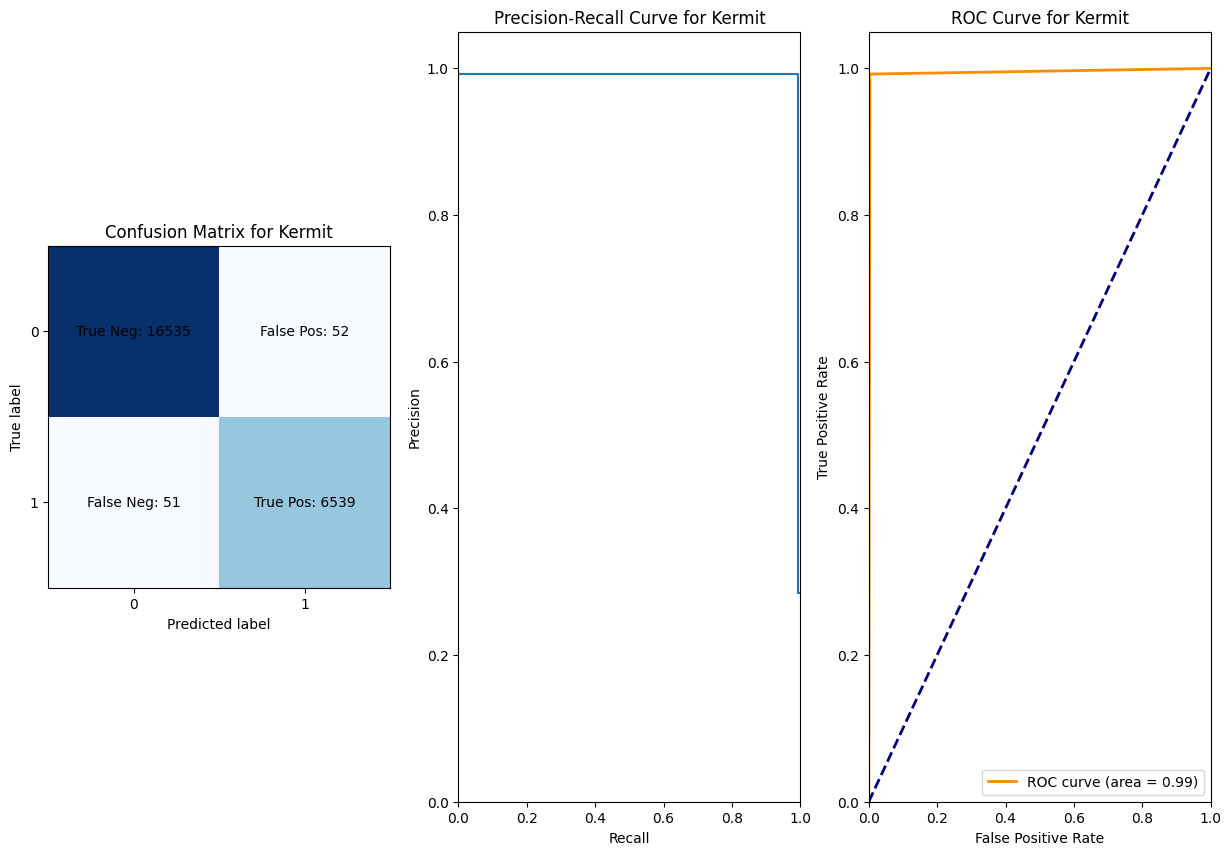

In [56]:
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["Kermit"], y_pred_kermit_hog)
precision = precision_score(y_test["Kermit"], y_pred_kermit_hog)
recall = recall_score(y_test["Kermit"], y_pred_kermit_hog)
f1 = f1_score(y_test["Kermit"], y_pred_kermit_hog)
conf_matrix = confusion_matrix(y_test["Kermit"], y_pred_kermit_hog)

# Print the metrics
print("Metrics for Kermit Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["Kermit"], y_pred_kermit_hog, "Confusion Matrix for Kermit", ax=axs[0]
)
plot_precision_recall_curve(
    y_test["Kermit"], y_pred_kermit_hog, "Precision-Recall Curve for Kermit", ax=axs[1]
)
plot_roc_curve(y_test["Kermit"], y_pred_kermit_hog, "ROC Curve for Kermit", ax=axs[2])

In [55]:
# training with hog only StatlerWaldorf
# training model for pdc only - Kermit
svm_hog_ws = SVC()

svm_hog_ws.fit(X_train_hog_scaled, y_train["StatlerWaldorf"])
y_pred_ws_hog = svm_hog_ws.predict(X_test_hog_scaled)

Metrics for StatlerWaldorf Predominant Color only: 
Accuracy: 0.999007636881391
Precision: 0.9830747531734838
Recall: 0.9844632768361582
F1 Score: 0.9837685250529287
Confusion Matrix:
[[22457    12]
 [   11   697]]


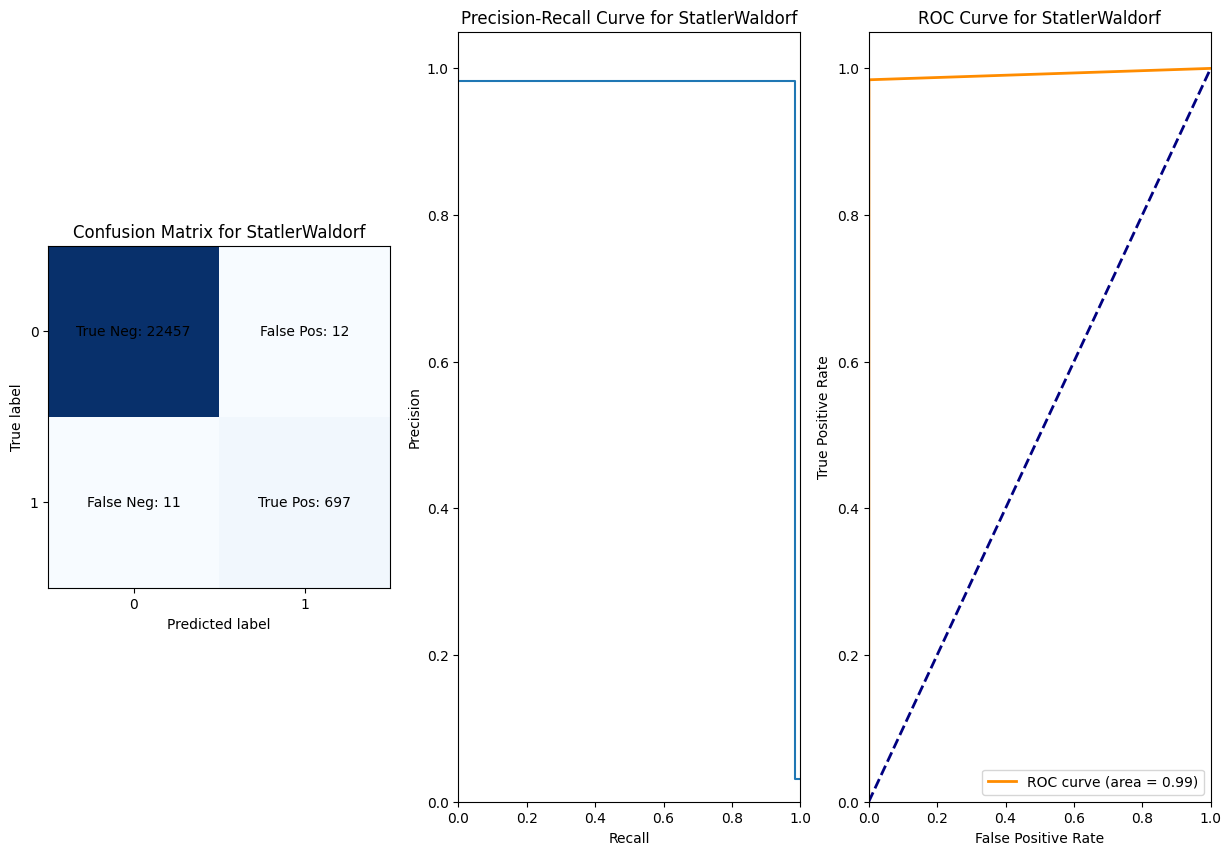

In [57]:
# Evaluation metrics for WaldorfStatler

accuracy = accuracy_score(y_test["StatlerWaldorf"], y_pred_ws_hog)
precision = precision_score(y_test["StatlerWaldorf"], y_pred_ws_hog)
recall = recall_score(y_test["StatlerWaldorf"], y_pred_ws_hog)
f1 = f1_score(y_test["StatlerWaldorf"], y_pred_ws_hog)
conf_matrix = confusion_matrix(y_test["StatlerWaldorf"], y_pred_ws_hog)

# Print the metrics
print("Metrics for StatlerWaldorf Predominant Color only: ")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

fig, axs = plt.subplots(1, 3, figsize=(15, 10))
# frog
plot_confusion_matrix(
    y_test["StatlerWaldorf"],
    y_pred_ws_hog,
    "Confusion Matrix for StatlerWaldorf",
    ax=axs[0],
)
plot_precision_recall_curve(
    y_test["StatlerWaldorf"],
    y_pred_ws_hog,
    "Precision-Recall Curve for StatlerWaldorf",
    ax=axs[1],
)
plot_roc_curve(
    y_test["StatlerWaldorf"], y_pred_ws_hog, "ROC Curve for StatlerWaldorf", ax=axs[2]
)

We spent many hours and computation time on trying to fit the edge features to the classification model, but very often ended up in OOM errors. When trying to save into csv file, we stopped after several hours as 1. the results of hog_features + predominant colour were satisfying, 2. we would not be able to compute the data for classification on our laptop anyways.


In [ ]:
columns = [f"edge_feat{i}" for i in range(2520)]
data_list = []

df = pd.DataFrame(columns=columns)
for video_idx in range(3):
    dataset.video_features = {}
for video_idx in dataset.frames.keys():
    for frame_idx, frame_path in tqdm(
        dataset.frames[video_idx],
        desc="Extracting visual features for video {}".format(video_idx),
        leave=False,
    ):
        frame_path = (
            "../data/video/" + str(video_idx) + "/frame_" + str(frame_idx) + ".png"
        )
        frame = cv2.imread(frame_path)
        # hog = dataset.video_features[video_idx]["frames"][frame_idx]["hog_features"]
        # predom_color = dataset.video_features[video_idx]["frames"][frame_idx][
        #     "predominant_color"
        # ]
        edge_features = get_edge_detection(frame)

        data_list.append({f"edge_feat{i}": val for i, val in enumerate(edge_features)})

df = pd.DataFrame(data_list)

# Display the DataFrame
print(df)

## Result discussion, observations and other things we tried to improve performance


As for the audio model, the he performance of the model has been evaluated under three angles:

- Kermit classification (metrics/plots for success at classifying frames where Kermit flag is true)
- StatlerWaldorf classification (metrics/plots for success at classifying frames where StatlerWaldorf flag is true)
- Overall classification performance (metrics/plots for the general multi-class classification task - weighted performance metrics have been employed).

The best performing model uses the following features (explanations on why we chose them for characteristics of the characters are given in the feature extraction part of the notebook):

- Predominant Color
- HOG features

These features are fed, as a vector of values, into a support vector machine. To ensure that we respect the demand for 3 "complex" methods from Sim2, we used a SVM classifier (from Sim2) here to compensate for the use of a random forest in sm2 (visual).

The model has been evaluated on a random split of the dataset, where 80% of the frames are used for training and 20% for testing.

**Model Performance with Random Split and all features:**

<table>
<thead>
 <tr>
 <th><b>Classification task</b></th>
 <th><b>F1</b></th>
 <th><b>Accuracy</b></th>
 <th><b>Precision</b></th>
 <th><b>Recall</b></th>
 </tr>
</thead>
<tbody>
 <tr>
 <td><b>Kermit detection</b></td>
 <td>0.9921</td>
 <td>0.9955</td>
 <td>0.9921</td>
 <td>0.9922</td>
 </tr>
 <tr>
 <td><b>Statler Waldorf detection</b></td>
 <td>0.9837</td>
 <td>0.9990</td>
 <td>0.9830</td>
 <td>0.9844</td>
 </tr>
 <tr>
 <td><b>Overall multi-class classification</b></td>
 <td>0.9946</td>
 <td>0.9946</td>
 <td>0.9946</td>
 <td>0.9946</td>
 </tr>
</tbody>
</table>

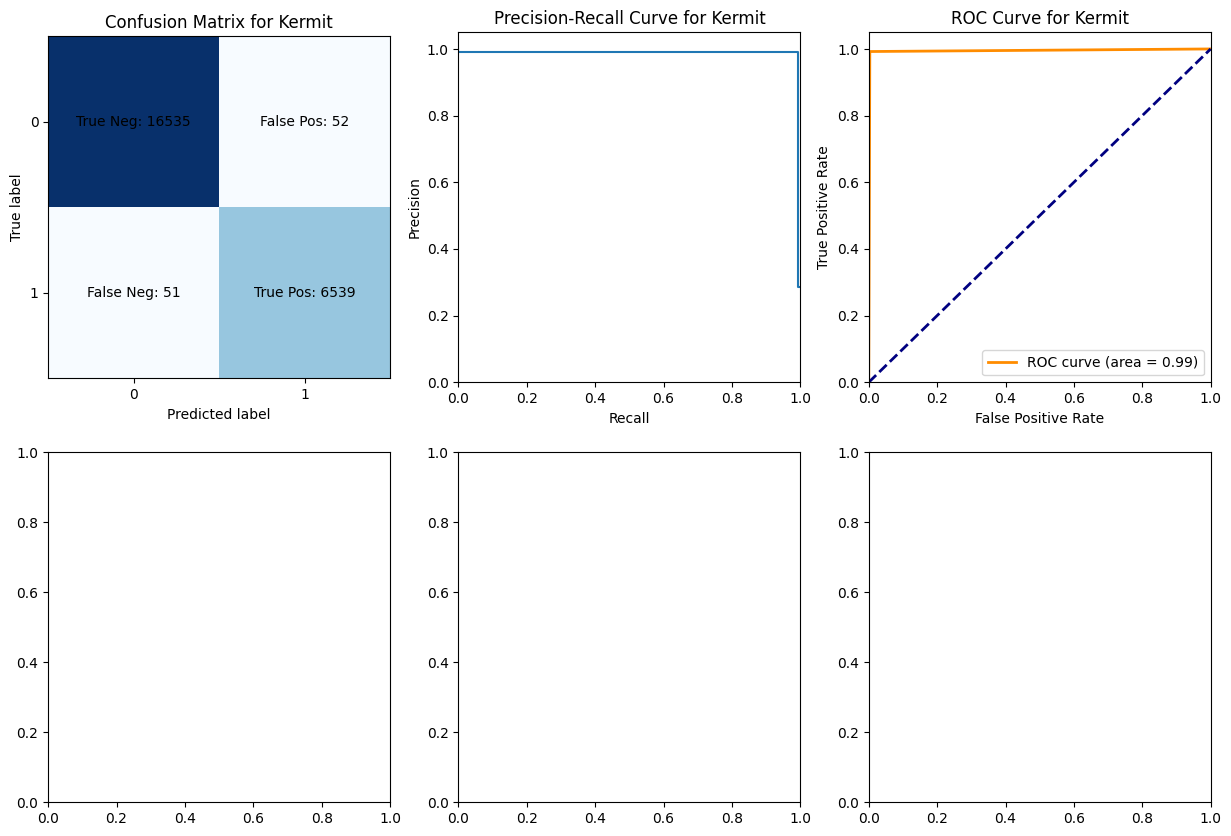
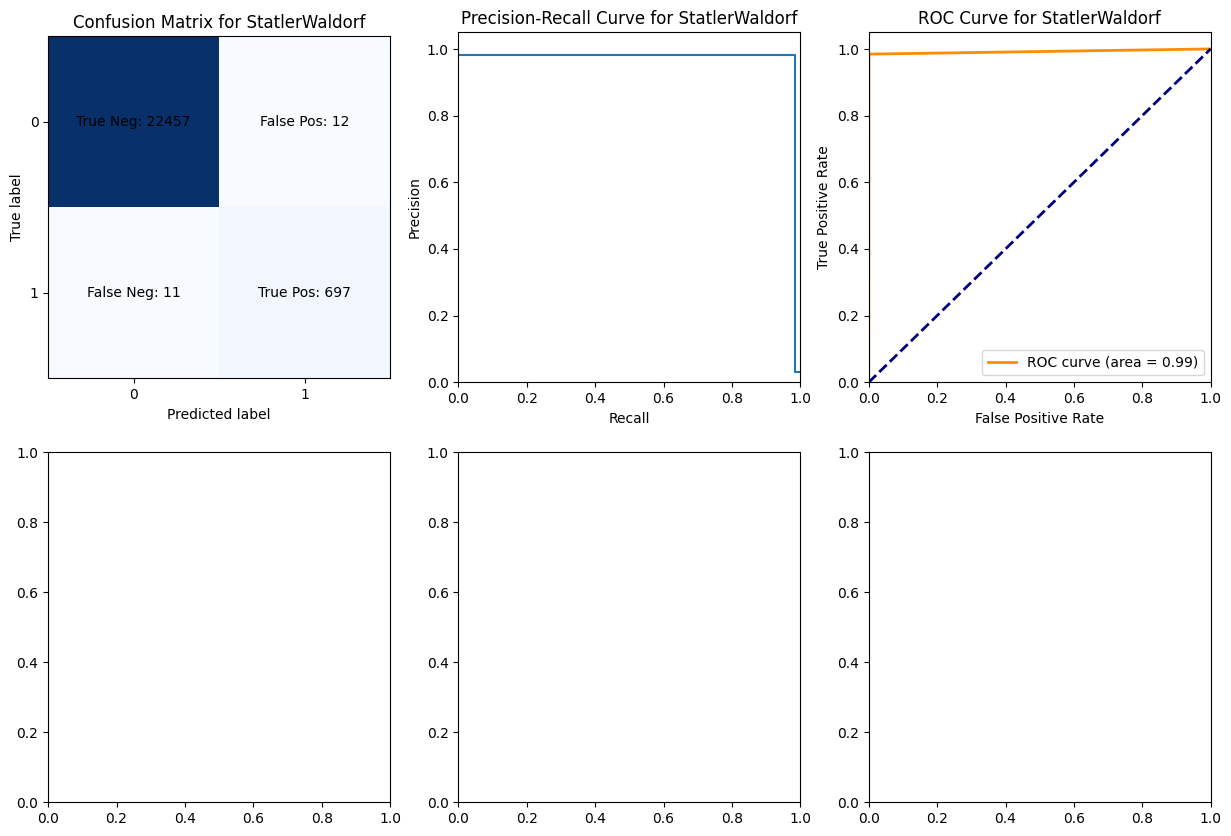
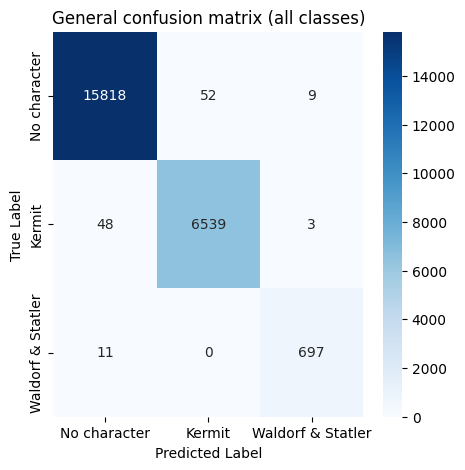

Besides combining both features for the models, we also trained models for predominant color and hog_features seperately.

For predominant color only the results looked like this:
**Predominant color only Model Performance with Random Split:**

<table>
<thead>
 <tr>
 <th><b>Classification task</b></th>
 <th><b>F1</b></th>
 <th><b>Accuracy</b></th>
 <th><b>Precision</b></th>
 <th><b>Recall</b></th>
 </tr>
</thead>
<tbody>
 <tr>
 <td><b>Kermit detection</b></td>
 <td>0.6373</td>
 <td>0.8287</td>
 <td>0.8009</td>
 <td>0.5292</td>
 </tr>
 <tr>
 <td><b>Statler Waldorf detection</b></td>
 <td>0.7887</td>
 <td>0.9861</td>
 <td>0.7365</td>
 <td>0.8488</td>
 </tr>
</tbody>
</table>

The models based on predominant color only worked quite okay. However, we assume that these models do not detect the characters by predominant color, but the background in which they occur. For instance, Kermit and Statler & Waldorf appear in front of the same background most of time and hence may be predicted to be present when said background is present.

For the model with hog features only the results looked as follows:
**hog features only Model Performance with Random Split:**

<table>
<thead>
 <tr>
 <th><b>Classification task</b></th>
 <th><b>F1</b></th>
 <th><b>Accuracy</b></th>
 <th><b>Precision</b></th>
 <th><b>Recall</b></th>
 </tr>
</thead>
<tbody>
 <tr>
 <td><b>Kermit detection</b></td>
 <td>0.9921</td>
 <td>0.9955</td>
 <td>0.9921</td>
 <td>0.9922</td>
 </tr>
 <tr>
 <td><b>Statler Waldorf detection</b></td>
 <td>0.7887</td>
 <td>0.9861</td>
 <td>0.7365</td>
 <td>0.8488</td>
 </tr>
</tbody>
</table>
The results of these models look exactely the same as for the combined approach, making hog features the most valualbe feature in our setting. The hog features probably worked well for classification as the different muppets have different texture features. With more computing power, we could have tuned the feature extraction further to probably achieve even better results.

We further tried to extract the hsv color histograms of the frames, but as it was advised not to use this approach we discarded it. It would have been interesting to see the direct comparison of hsv color histograms and predomoninant color.

The edge features seemed to be the most promising feature, however, at a high cost. Our hardware was unable to process the features for classification as for each frame there would be > 2000 edge features. Several overnight runs and attempts to save to csv file have failed due to OOM errors.

Overall, we are quite satisfied with the results of this approach.
